<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/VariationalAutoencoderUsingPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Cài đặt

>Imports

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np

>Helpers

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(in_, out, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 4))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):
  
  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))

  for i, ax in enumerate(axarr.flat):
      ax.imshow(images[i].view(img_dim, img_dim))
      ax.axis('off')
      
  plt.suptitle(title)
  plt.show()

>Globals

In [3]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

#B. Dataset

>Load MNIST

In [4]:
batch_size = 256

In [ ]:
# chuyển đổi để áp dụng cho từng điểm dữ liệu (hình ảnh)
transformer = lambda x: transforms.ToTensor()(x)

# xác định tập dữ liệu đào tạo và kiểm tra
ds_train = MNIST("./data", train=True, transform=transformer, download=True)
ds_test = MNIST("./data", train=False, transform=transformer)

# bộ tải dữ liệu để tải dữ liệu theo lô từ bộ dữ liệu
train_loader = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
test_loader = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

>Plot Random Samples

In [ ]:
plot_samples_grid(train_loader, title='Original Images (Before Binarization)')

>Transform to Binarized MNIST

In [ ]:
def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

# xác định tập dữ liệu đào tạo và kiểm tra
bin_ds_train = MNIST("./bin_data", train=True, transform=binarizer, download=True)
bin_ds_test = MNIST("./bin_data", train=False, transform=binarizer)

# tải dữ liệu đến dataset
bin_train_loader = DataLoader(dataset=bin_ds_train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)
bin_test_loader = DataLoader(dataset=bin_ds_test, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=cuda)

>Plot Binarized MNIST Samples

In [ ]:
plot_samples_grid(bin_train_loader, title='Binarized Images')

#C. VAE

>Cài đặt và triển khai model


In [9]:
latent_size = 20

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, latent_size)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((n_samples, latent_size)).to(device)
      return self.decode(z)

model = VAE().to(device)

In [11]:
# Tối ưu hoá
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [12]:
# Reconstruction + KL divergence losses 
def loss_function(x_hat, x, mu, logvar):
    
    # reconstruction loss (đẩy các điểm xa nhau)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )

    # KL divergence loss 
    # (bán kính = 1 + từ = 0)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # (BCE + beta * KLD)

>Tạo mẫu từ mô hình chưa được đào tạo

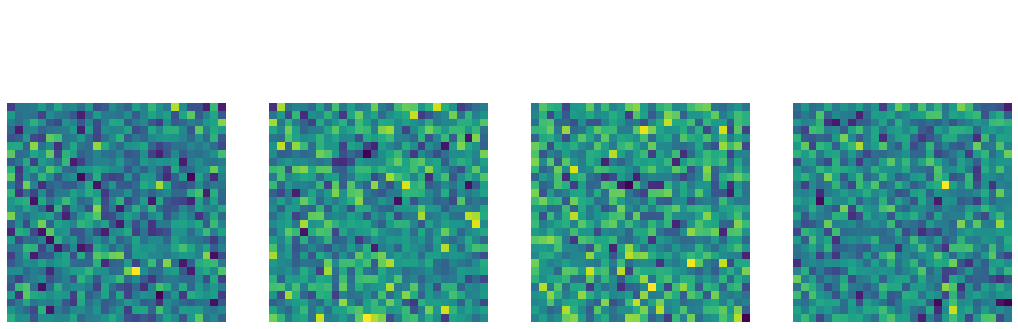

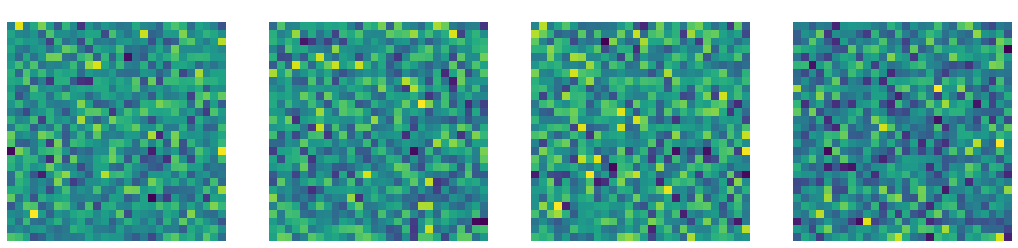

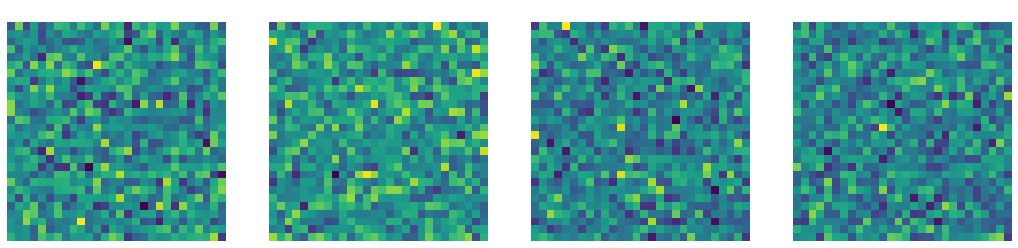

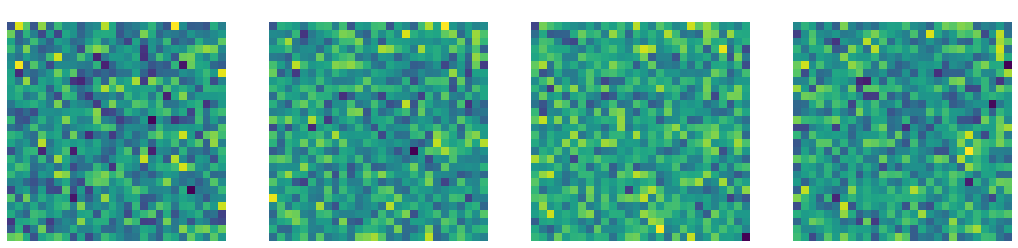

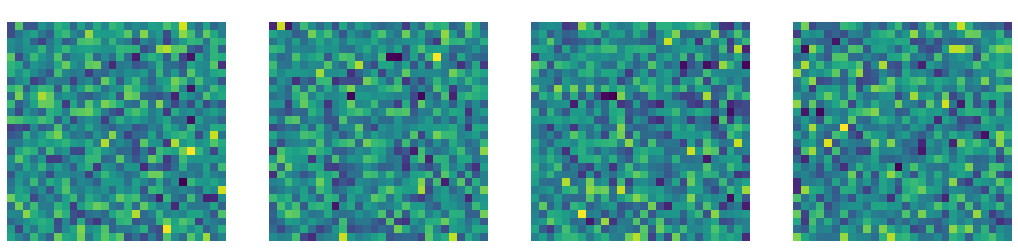

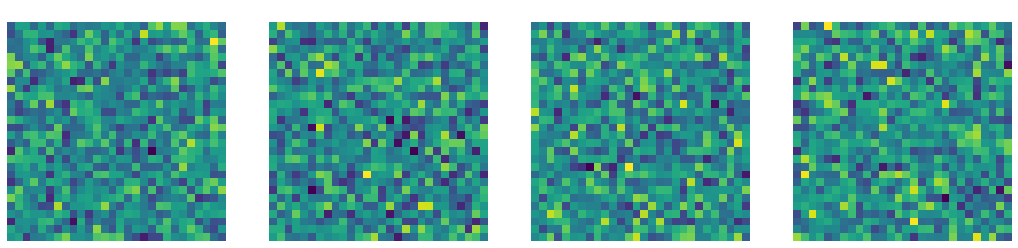

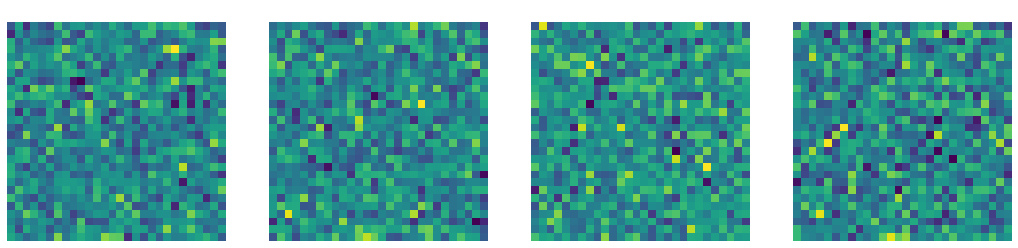

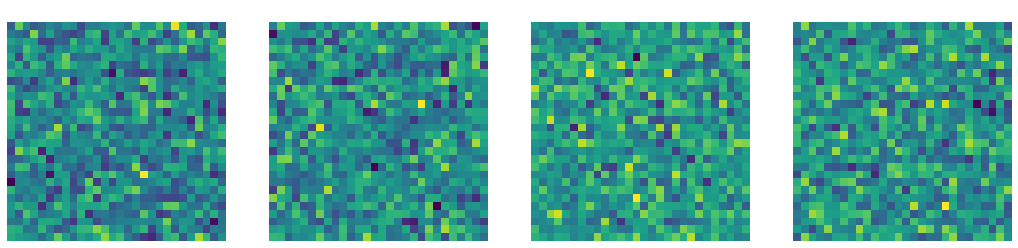

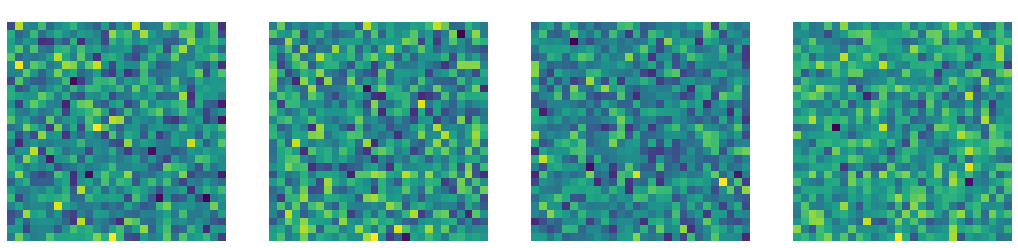

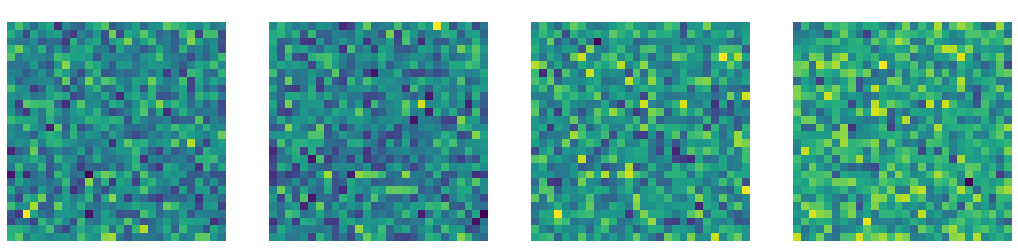

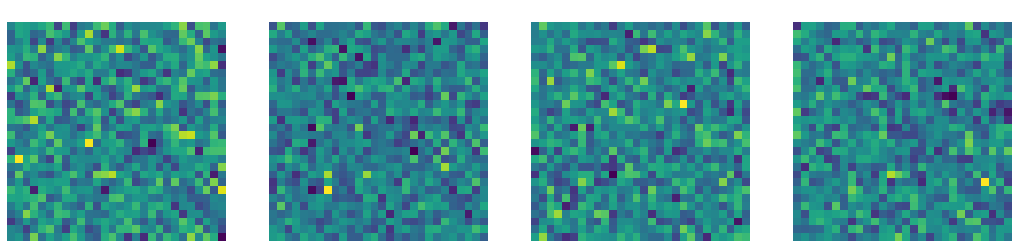

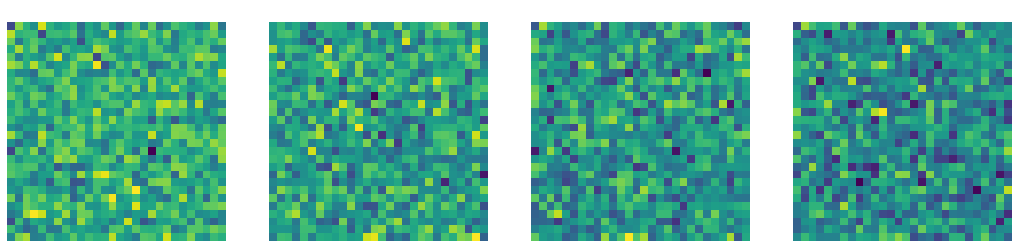

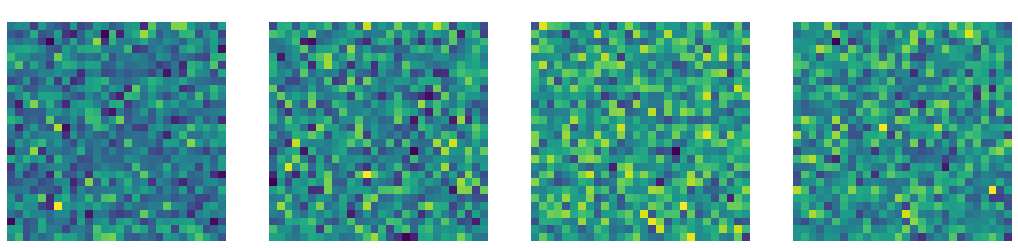

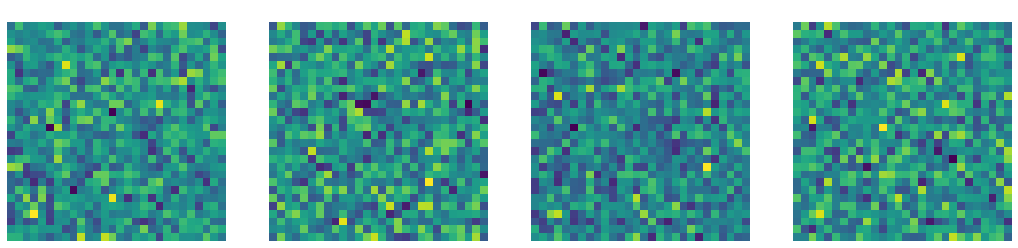

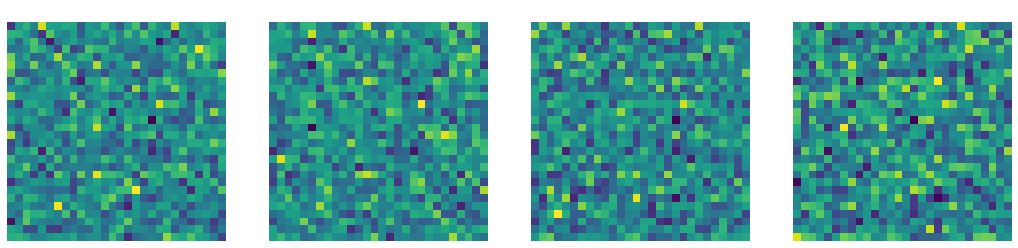

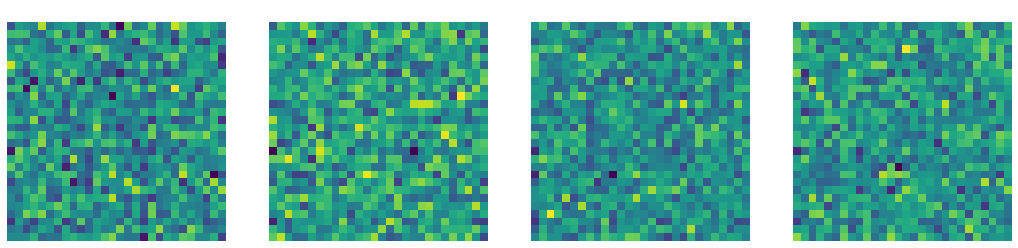

In [13]:
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Untrained Model', 64 // 4, count=True)

>ELBO của các mẫu từ tập huấn luyện sử dụng mô hình chưa được huấn luyện

In [14]:
with torch.no_grad():
  model.eval()
  # Tải data gồm 256 mẫu
  images, _ = next(iter(bin_train_loader))
  # Sử dụng 64 mẫu
  only_64 = images[0:64, :, :, :]
  # Gửi chúng đến device
  only_64 = only_64.to(device)
  # forward
  x_hat, mu, logvar = model(only_64)
  
  elbo_64_untrained = loss_function(x_hat, only_64, mu, logvar).item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 34865.0547


>Cài đặt và kiểm tra hàm train

In [15]:
# Thực hiện train epoch và trả về epoch loss 
def train():
  model.train()
  train_loss = 0
  for x, _ in bin_train_loader:
    x = x.to(device)
    # ===================forward=====================
    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

# đánh giá mô hình trên bộ thử nghiệm
def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in bin_test_loader:
      x = x.to(device)
      # forward
      x_hat, mu, logvar = model(x)
      test_loss += loss_function(x_hat, x, mu, logvar).item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
  return test_loss, means, logvars, labels, images

>Đào tạo mô hình và đánh giá trên bộ kiểm tra

====> Epoch: 1 Average train loss: 184.7304
====> Epoch: 1 Average test loss: 126.5415
====> Epoch: 2 Average train loss: 122.5371
====> Epoch: 2 Average test loss: 103.2247
====> Epoch: 3 Average train loss: 108.4920
====> Epoch: 3 Average test loss: 94.7550
====> Epoch: 4 Average train loss: 102.1498
====> Epoch: 4 Average test loss: 89.6093
====> Epoch: 5 Average train loss: 98.4370
====> Epoch: 5 Average test loss: 86.5022
====> Epoch: 6 Average train loss: 95.9921
====> Epoch: 6 Average test loss: 85.8891
====> Epoch: 7 Average train loss: 94.1113
====> Epoch: 7 Average test loss: 83.0822
====> Epoch: 8 Average train loss: 92.6994
====> Epoch: 8 Average test loss: 82.6922
====> Epoch: 9 Average train loss: 91.5324
====> Epoch: 9 Average test loss: 81.9176
====> Epoch: 10 Average train loss: 90.6530
====> Epoch: 10 Average test loss: 81.0914
====> Epoch: 11 Average train loss: 89.8268
====> Epoch: 11 Average test loss: 80.5825
====> Epoch: 12 Average train loss: 89.1466
====> Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


====> Epoch: 22 Average train loss: 85.3731
====> Epoch: 22 Average test loss: 76.6299
====> Epoch: 23 Average train loss: 85.1727
====> Epoch: 23 Average test loss: 76.9150
====> Epoch: 24 Average train loss: 85.0124
====> Epoch: 24 Average test loss: 75.7481
====> Epoch: 25 Average train loss: 84.7689
====> Epoch: 25 Average test loss: 77.0372
====> Epoch: 26 Average train loss: 84.5495
====> Epoch: 26 Average test loss: 76.5767
====> Epoch: 27 Average train loss: 84.3822
====> Epoch: 27 Average test loss: 76.2367
====> Epoch: 28 Average train loss: 84.2014
====> Epoch: 28 Average test loss: 75.7837
====> Epoch: 29 Average train loss: 84.0327
====> Epoch: 29 Average test loss: 76.5766
====> Epoch: 30 Average train loss: 83.9190
====> Epoch: 30 Average test loss: 75.9999
====> Epoch: 31 Average train loss: 83.7218
====> Epoch: 31 Average test loss: 76.1758
====> Epoch: 32 Average train loss: 83.6239
====> Epoch: 32 Average test loss: 75.0345
====> Epoch: 33 Average train loss: 83.4966

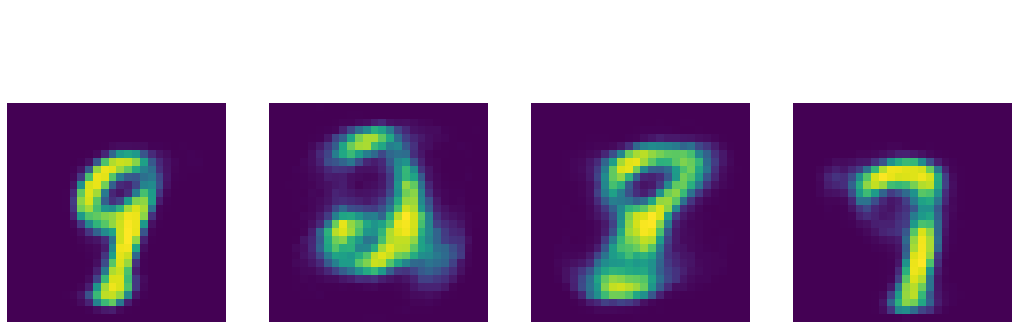

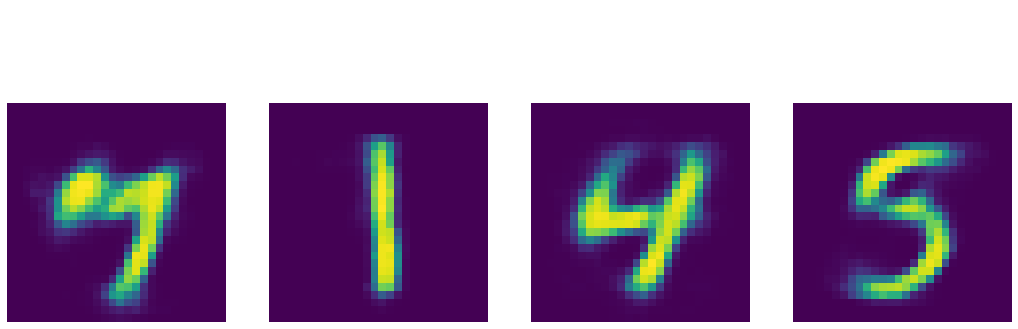

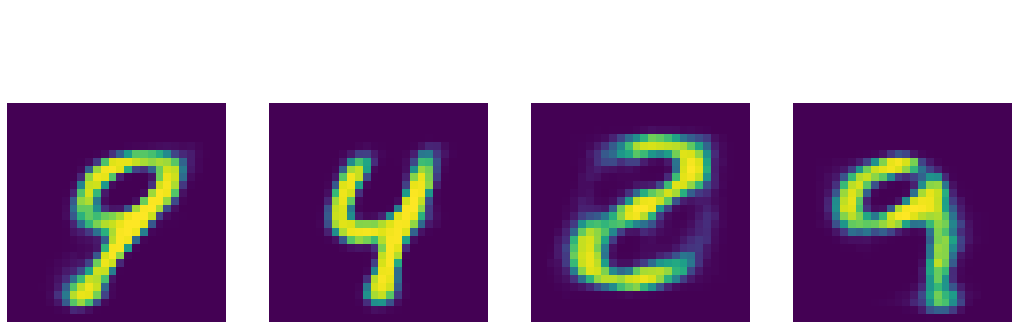

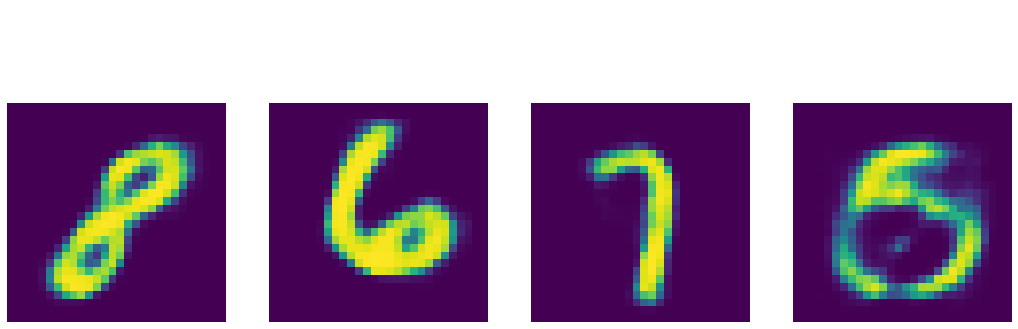

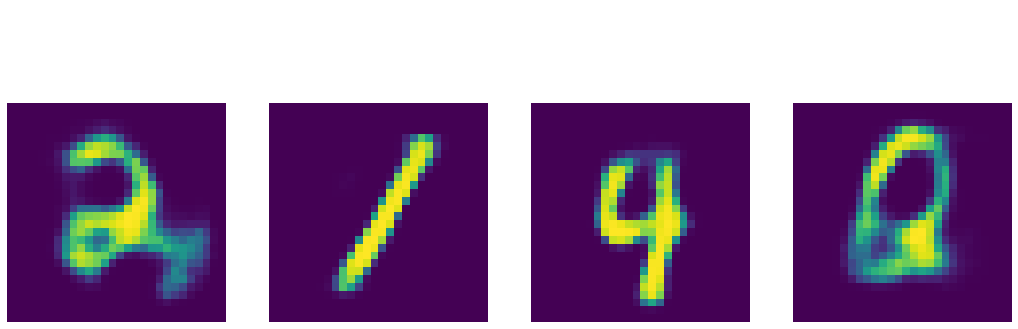

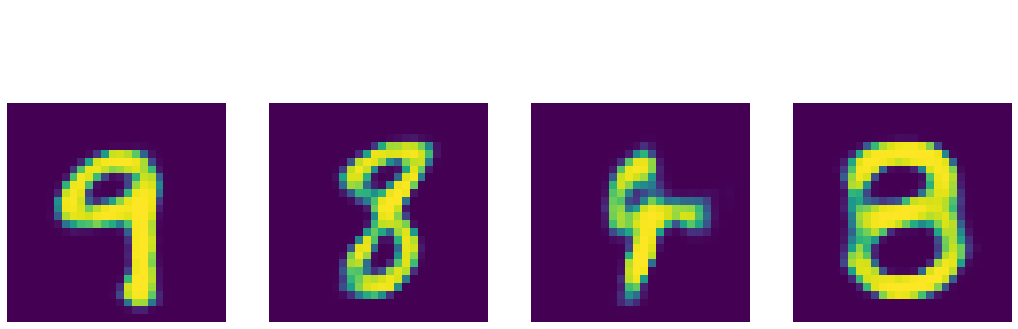

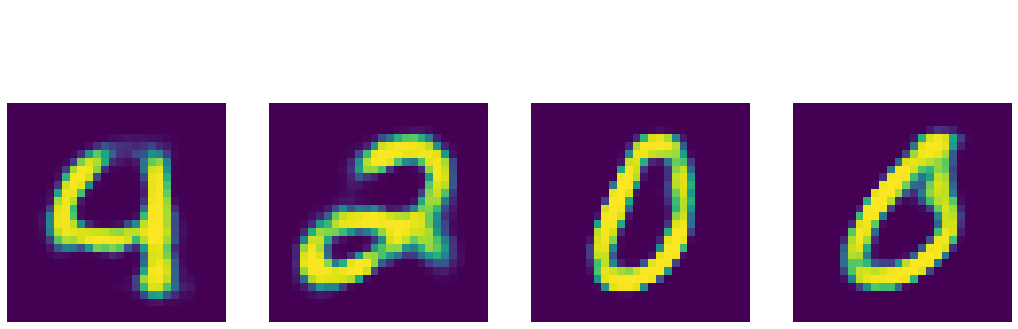

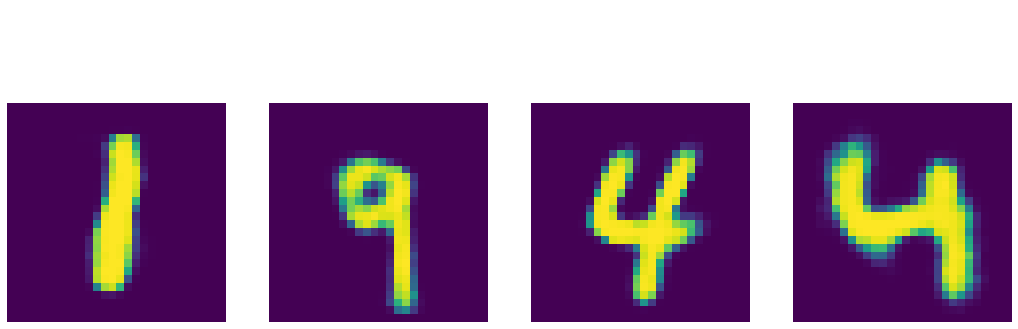

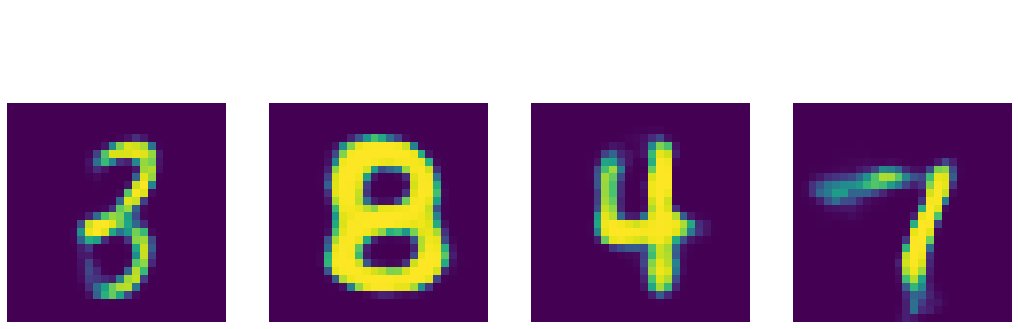

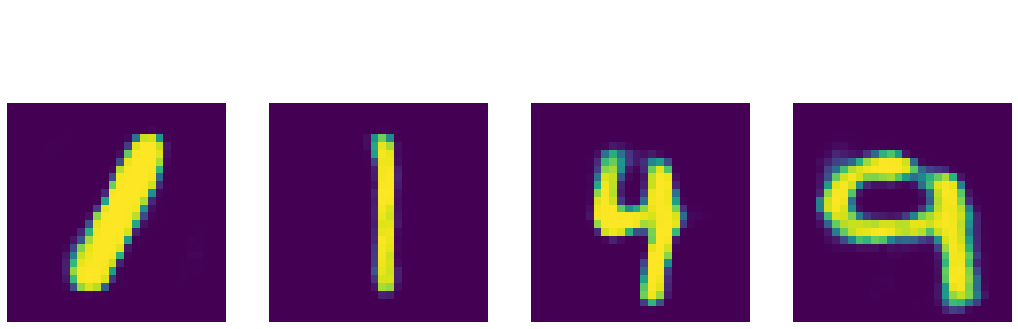

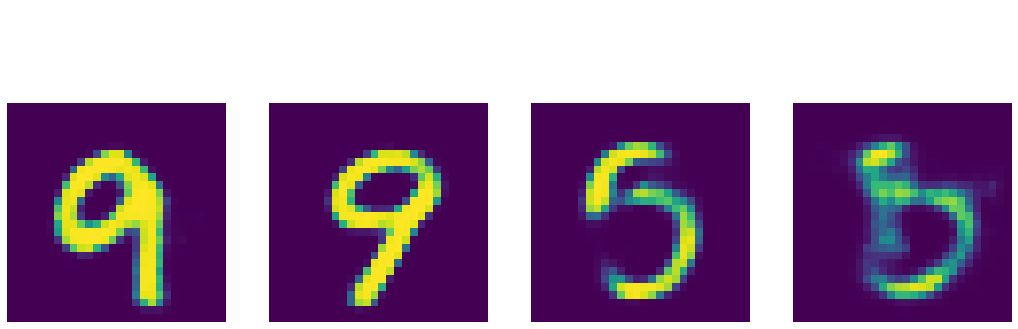

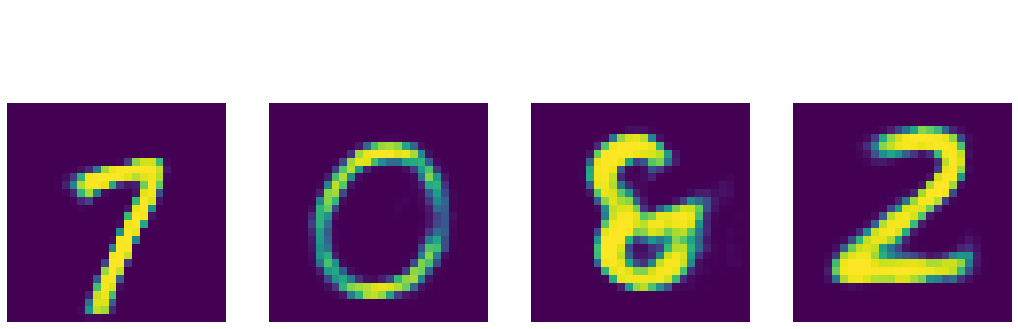

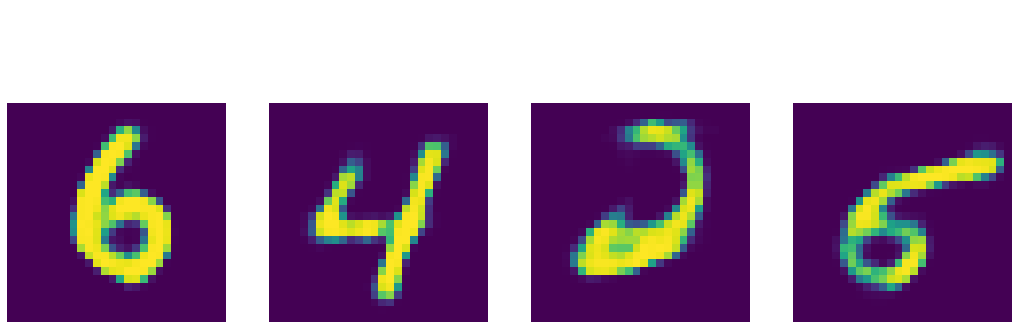

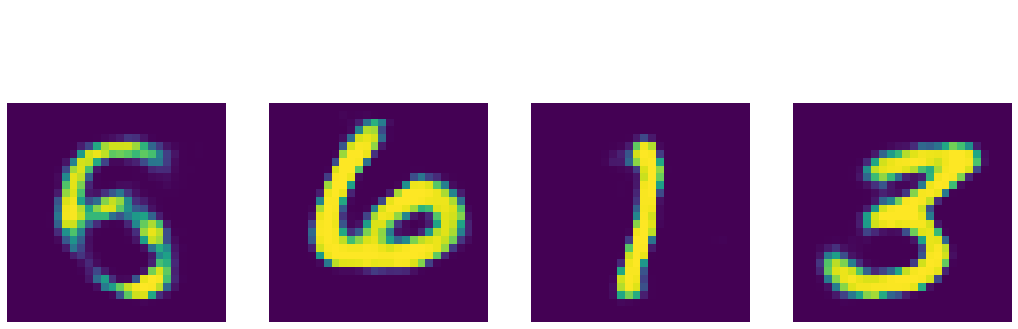

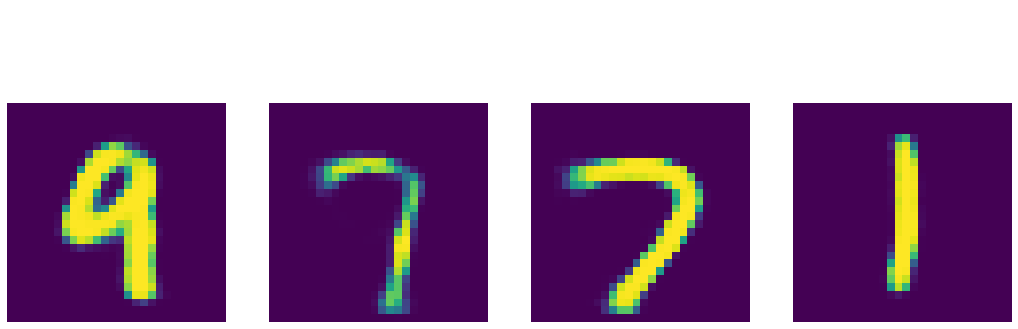

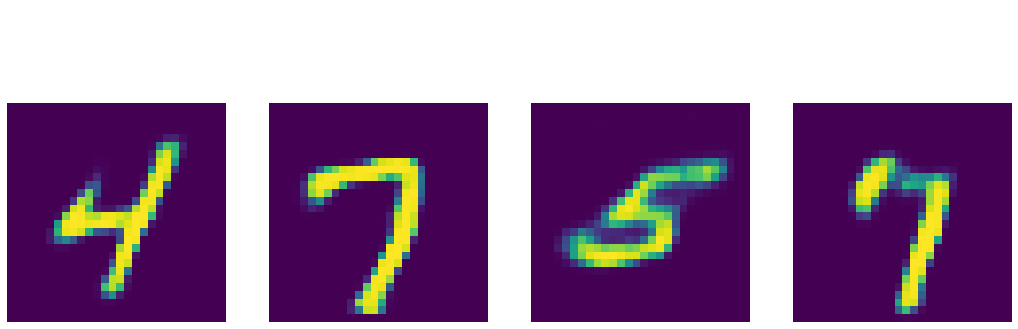

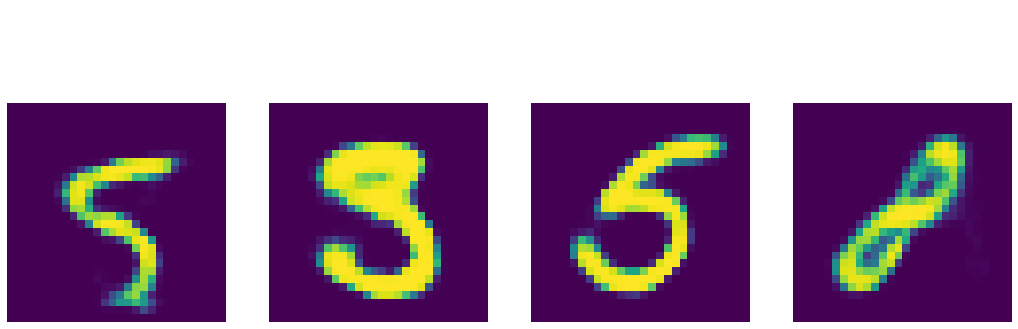

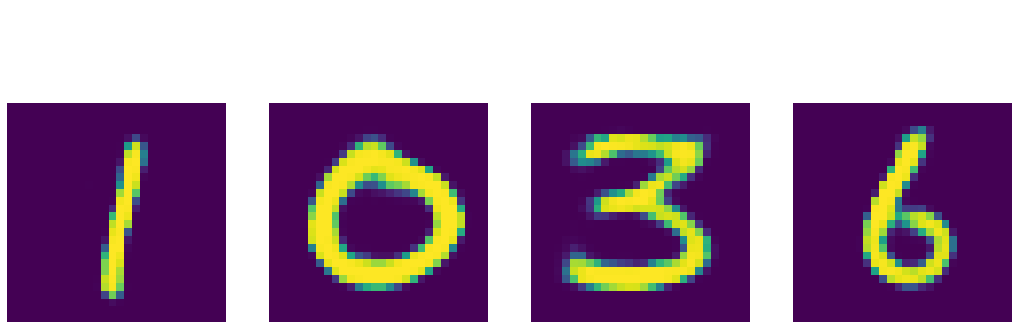

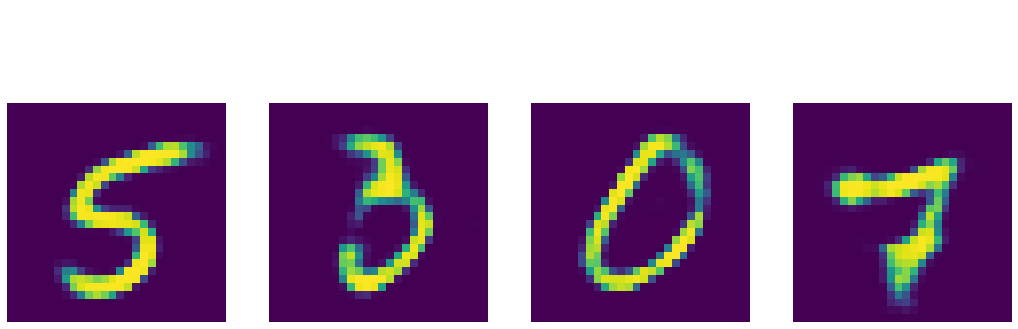

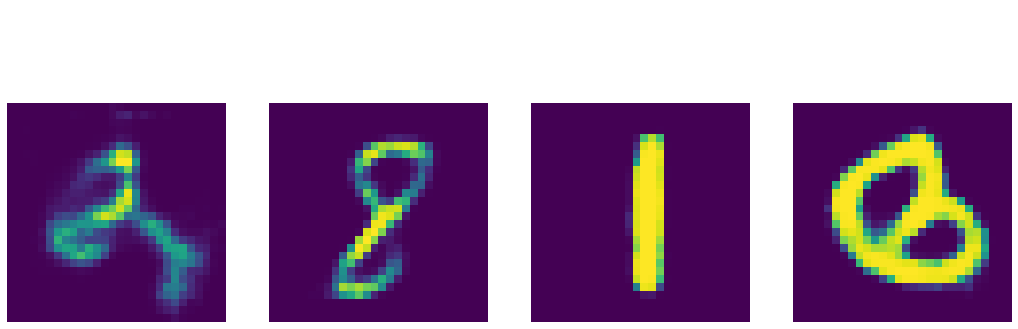

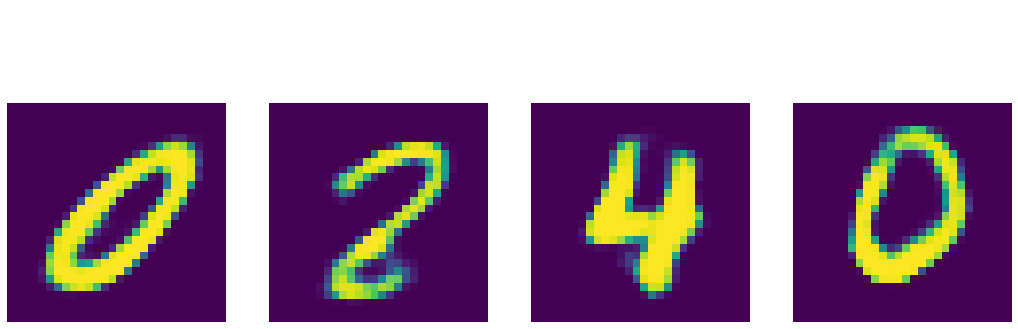

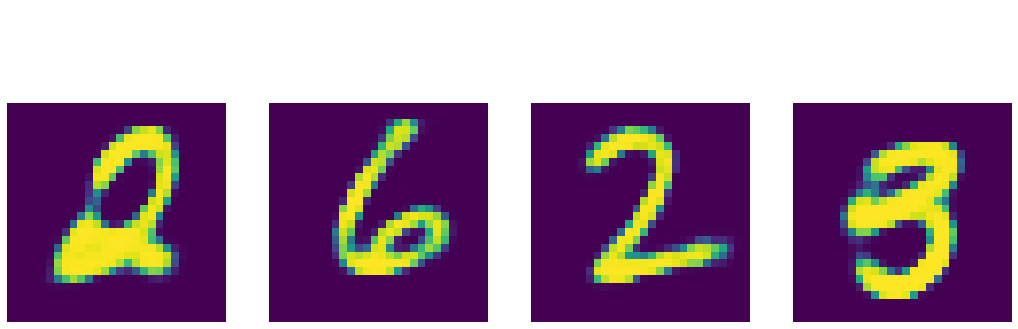

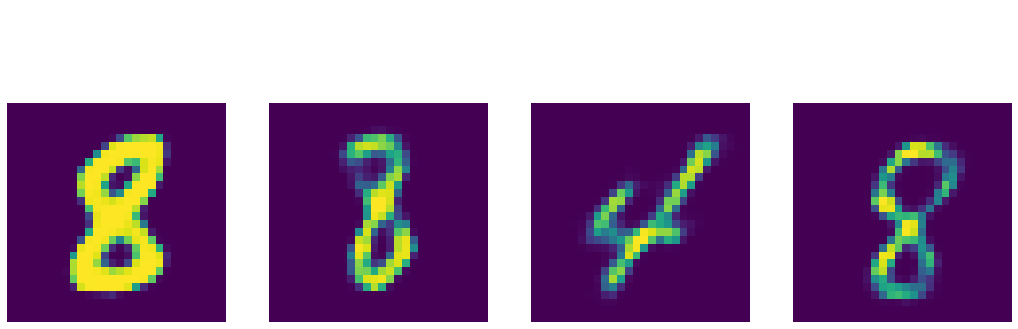

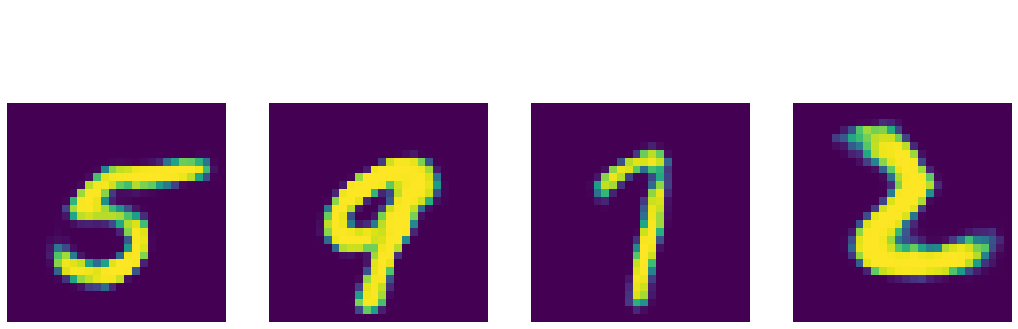

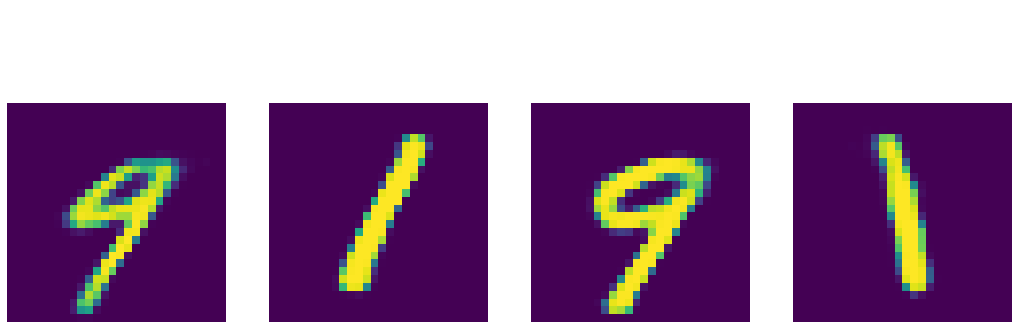

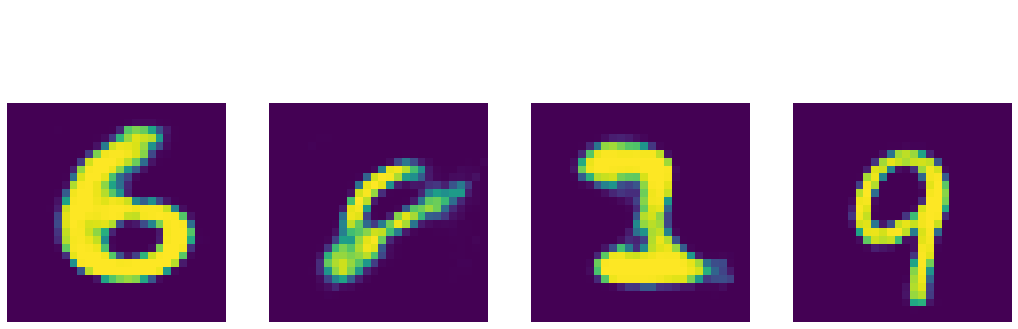

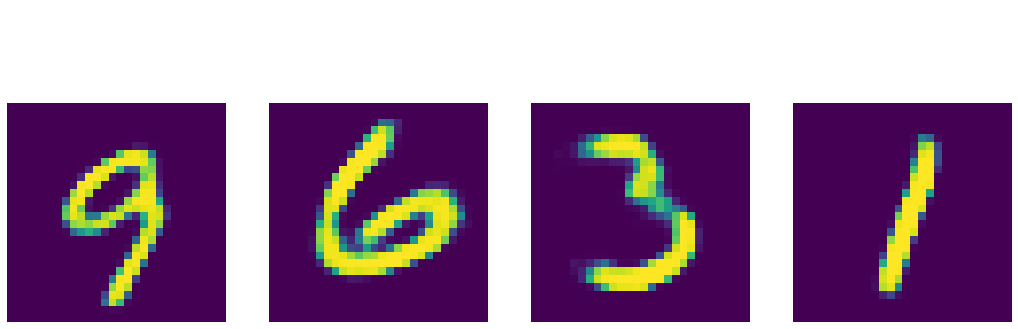

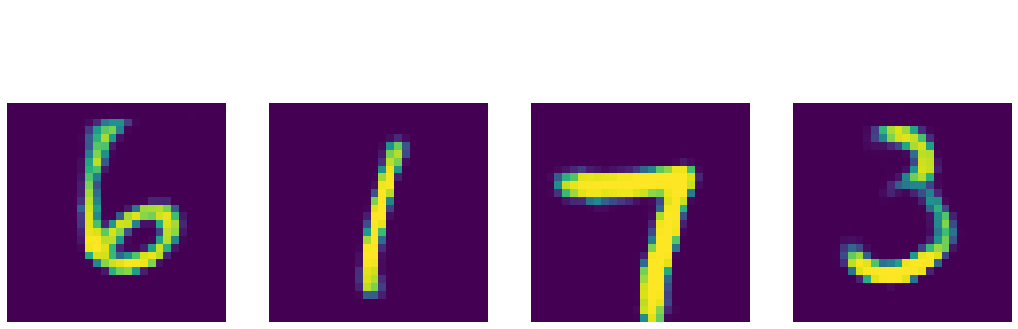

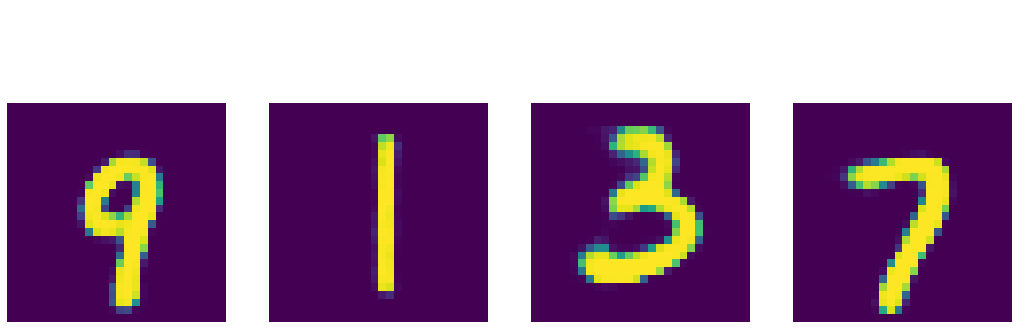

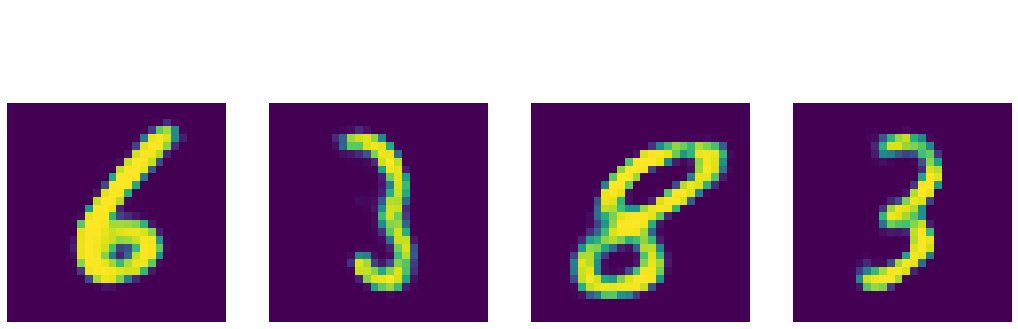

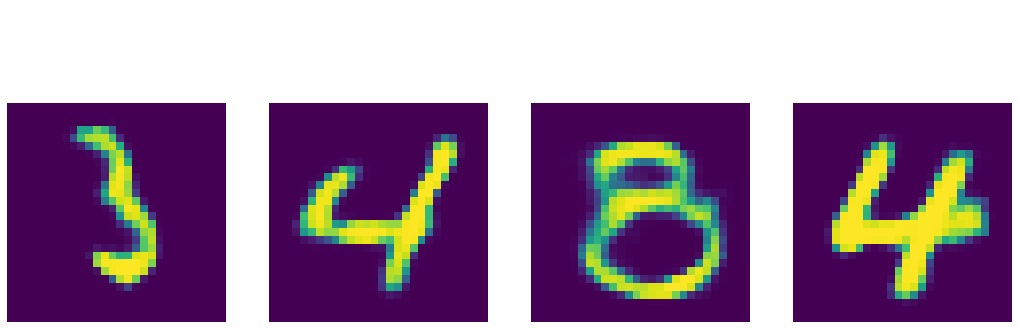

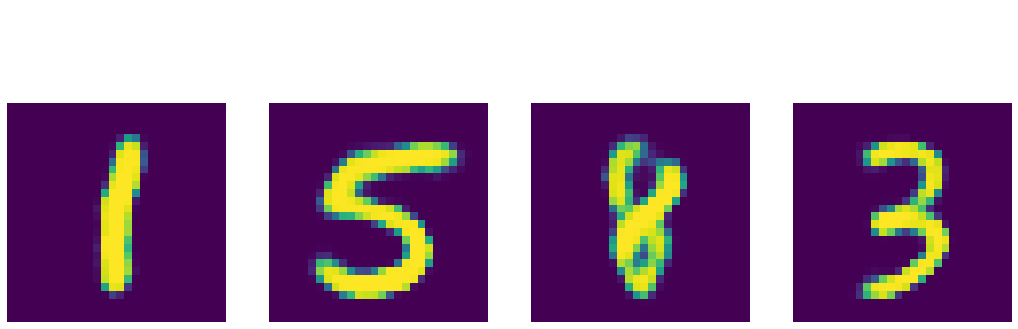

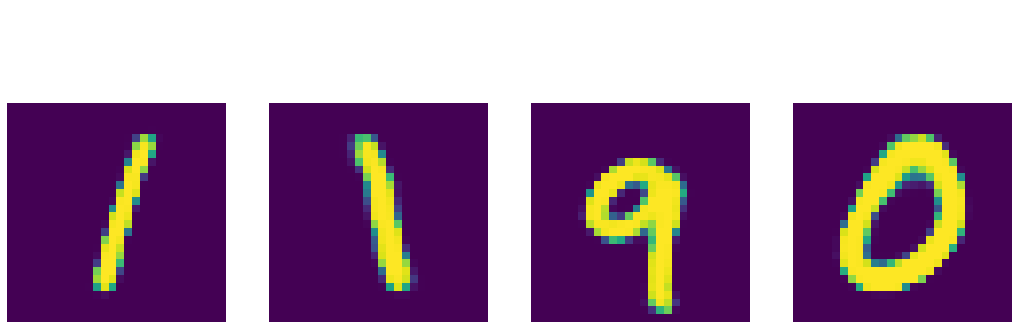

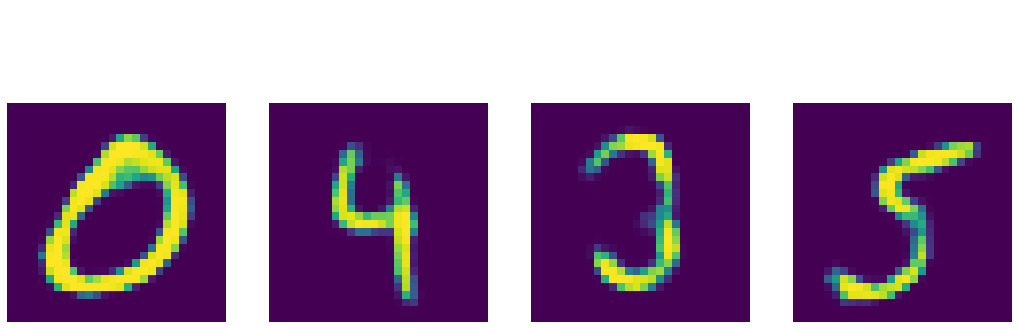

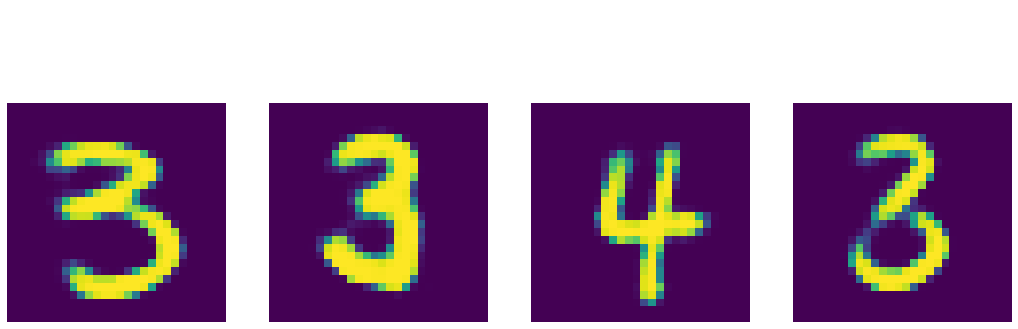

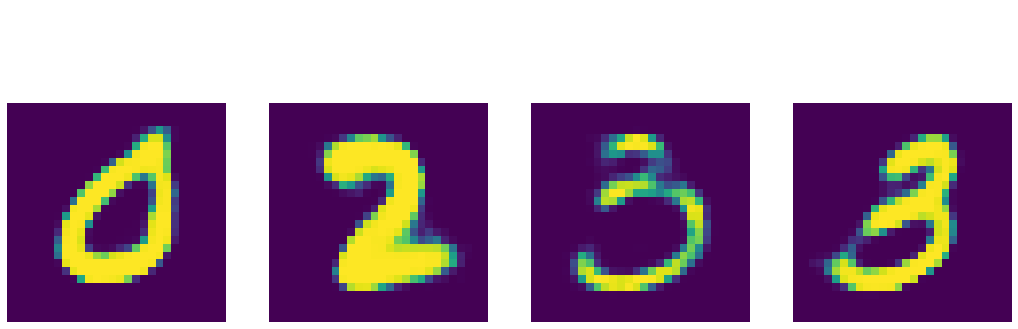

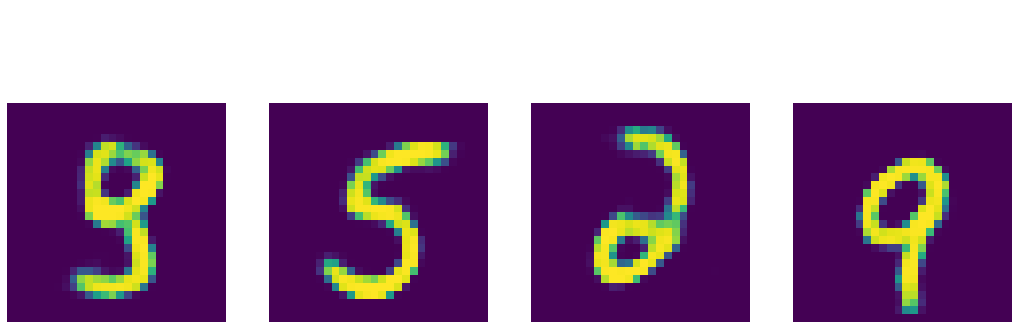

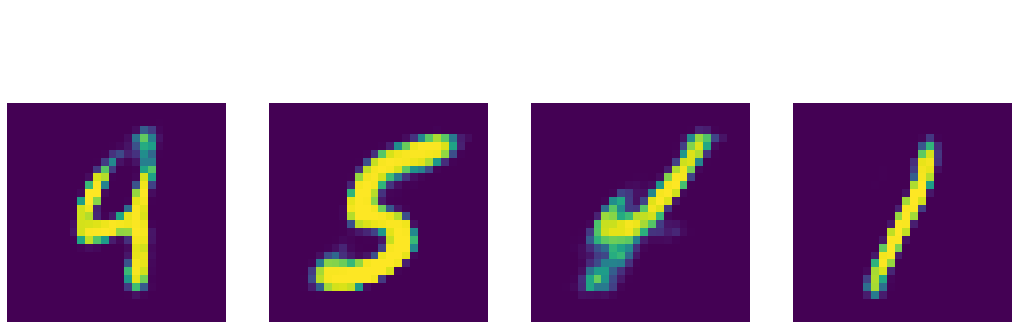

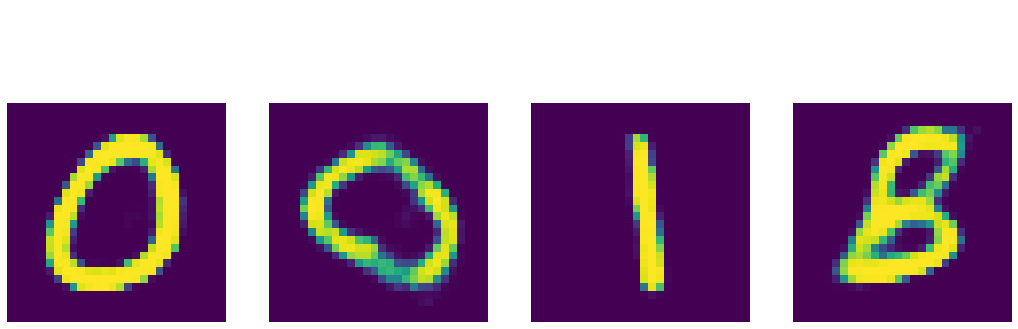

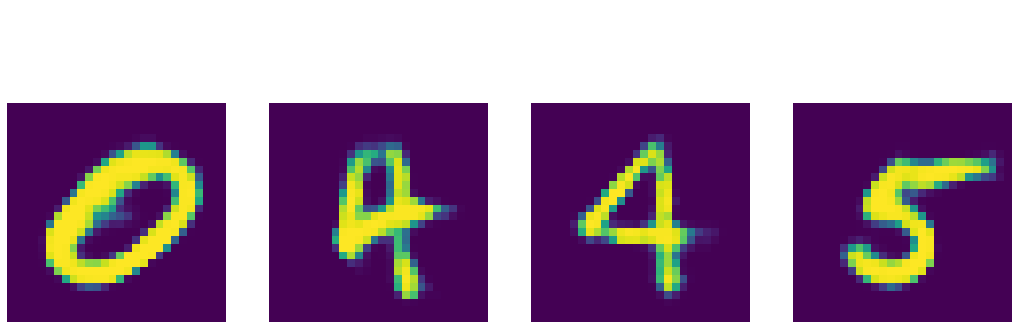

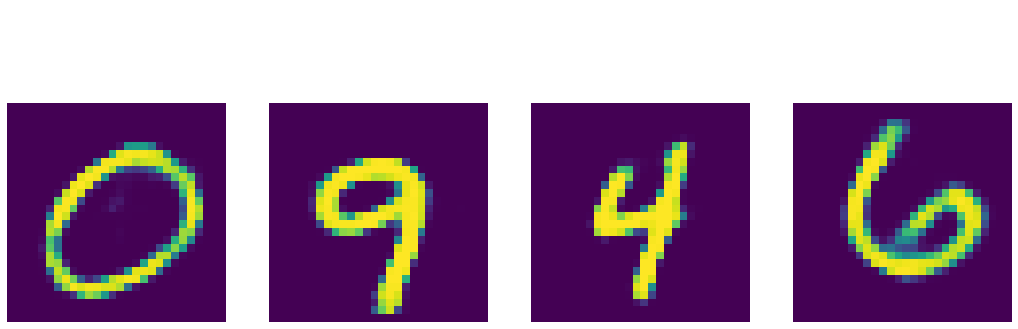

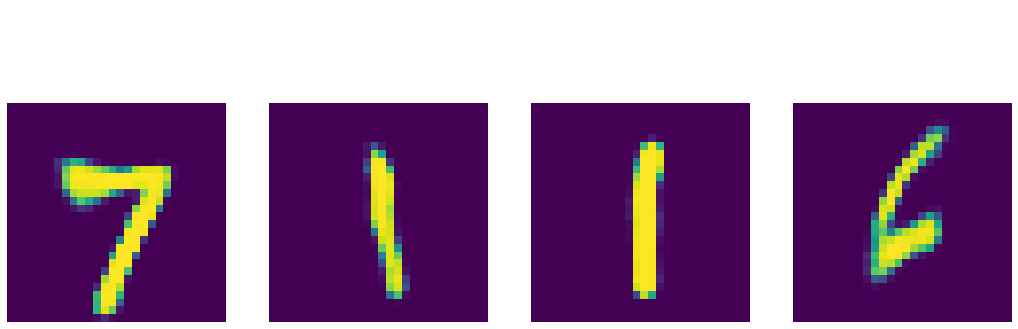

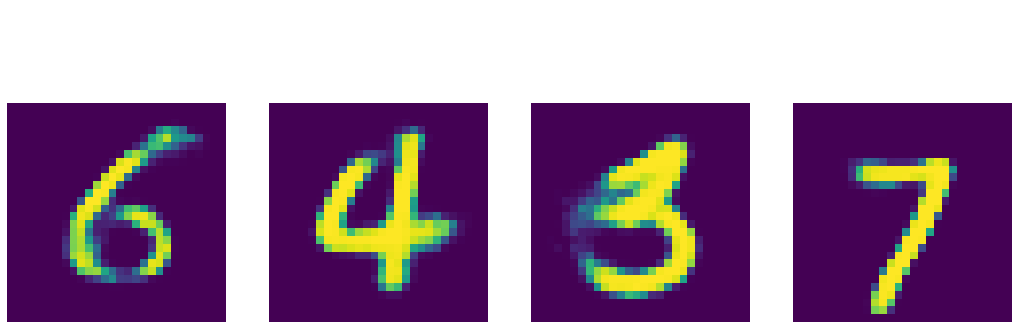

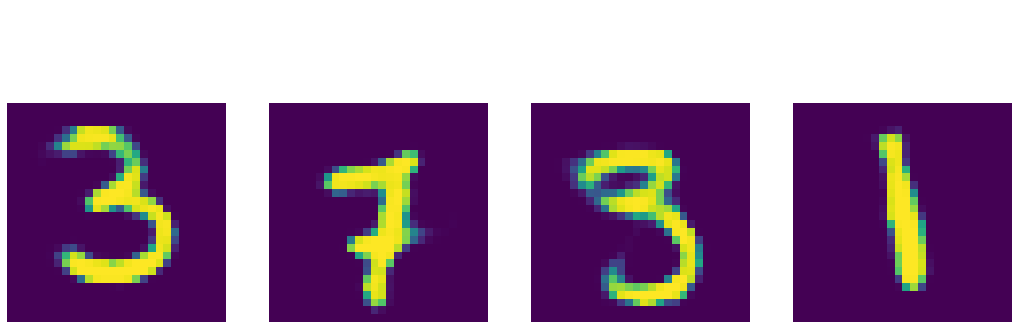

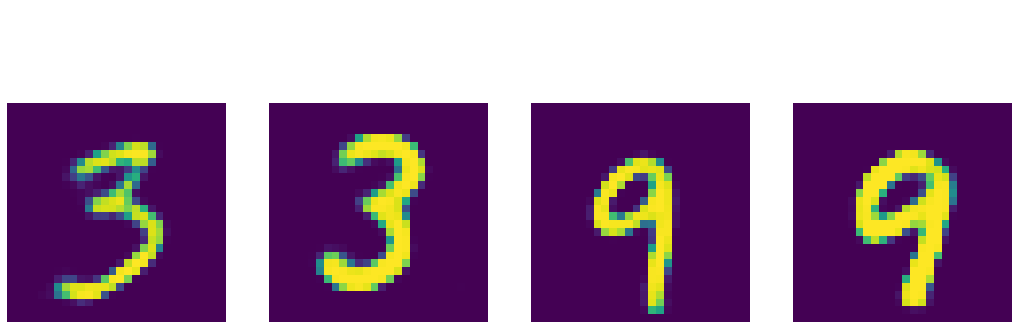

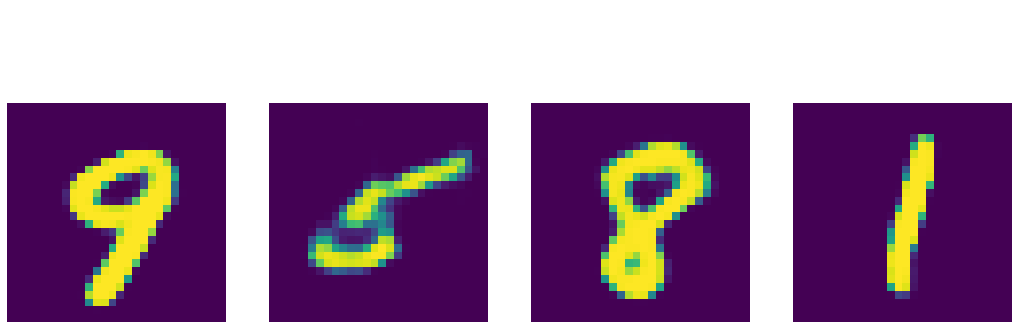

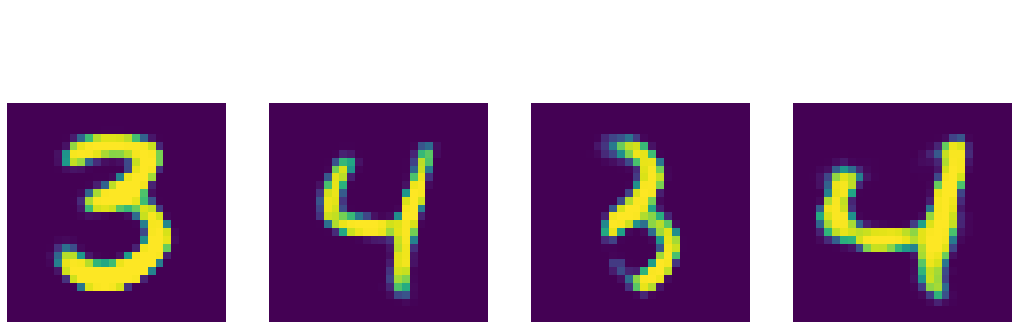

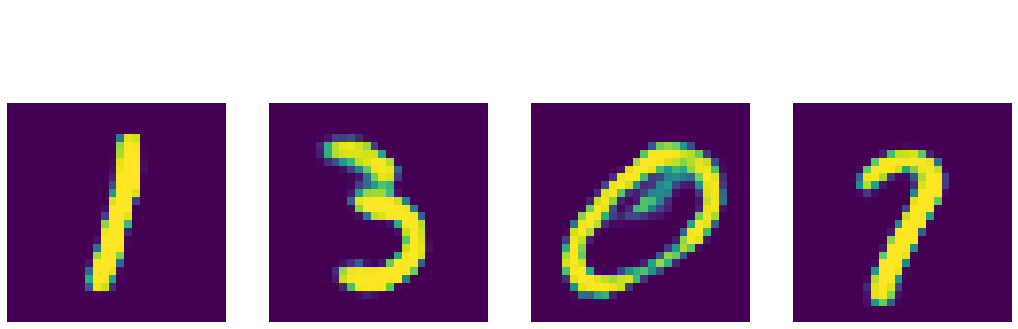

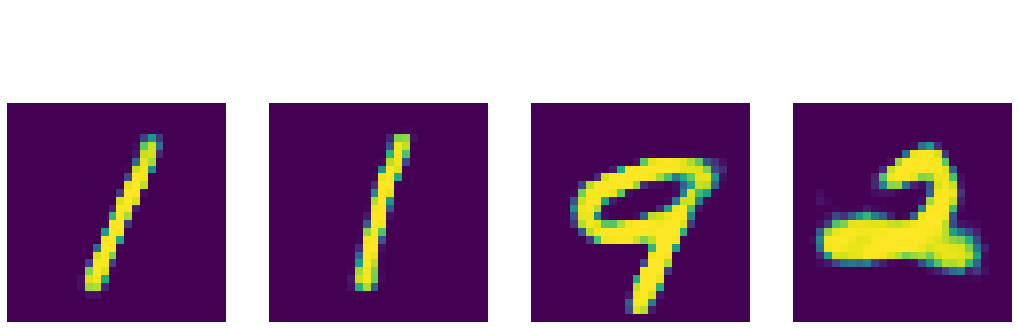

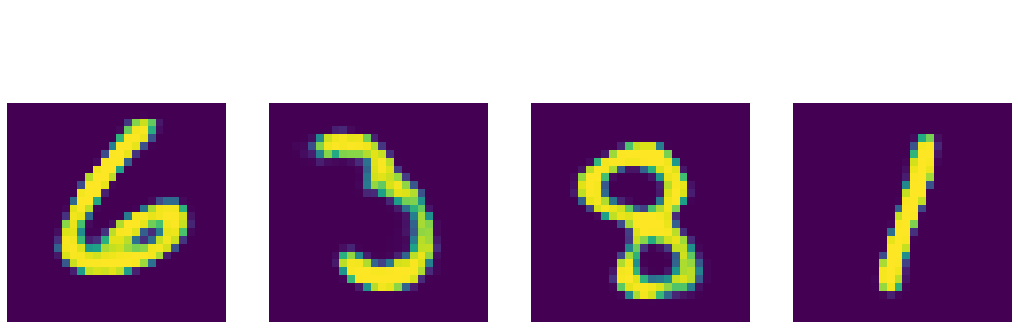

In [16]:
# Training model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):
    
    # train one epoch
    train_loss = train()

    # print train loss epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(bin_train_loader.dataset):.4f}')
    
    # đánh giá epoch test
    test_loss, means, logvars, labels, images = test(epoch)

    # phân tích
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    codes['x'].append(torch.cat(images))

    # print the test loss for the epoch
    print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(bin_test_loader.dataset):.4f}')

In [ ]:
# Lưu trạng thái model
torch.save(model.state_dict(), 'vae-model.pt')

In [ ]:
# loading module đã lưu
model = VAE().to(device)
model.load_state_dict(torch.load('vae-model.pt'))

>Tạo mẫu từ mô hình được đào tạo

In [ ]:
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True)

#D. Phân tích model

>Nội suy - Bắt đầu và Kết thúc

In [ ]:
# Chọn điểm bắt đầu và điểm kết thúc cho nội suy -> hiển thị nguyên bản và tái tạo
A, B = 12, 26
sample = model.decoder(torch.stack((codes['μ'][epoch-1][A].data, codes['μ'][epoch-1][B].data), 0))
display_images(None, torch.stack(((
    codes['x'][epoch-1][A].data.view(-1),
    codes['x'][epoch-1][B].data.view(-1),
    sample.data[0],
    sample.data[1]
))), 'Interpolation Start and End')

>Nội suy trong N

In [ ]:
# Thực hiện nội suy tuyến tính giữa 2 đầu vào A và B trong không gian tiềm ẩn và gửi nó qua bộ giải mã
# Ở trong không gian ẩn có thể tái tạo giống đầu vào
N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * codes['μ'][epoch-1][B].data + (1 - i / (N - 1) ) * codes['μ'][epoch-1][A].data
sample = model.decoder(code)
display_images(None, sample, 'Interpolation in N steps', N // 4, count=True)

>Vẽ không gian ẩn

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples epoch
epochs = (0, 24, 49)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [ ]:
set_default(figsize=(20, 6))

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

#E. Semi-Supervised VAE

>Tạo tập dữ liệu con từ dataset

In [ ]:
# extract 100 labeled datapoints (10 from each class)
data_list, targets_list = [], []

# take 10 of each class
for class_ in range(10):
  idx = bin_ds_train.targets == class_
  data_list.append(bin_ds_train.data[idx][0:10, :, :])
  targets_list.append(bin_ds_train.targets[idx][0:10])

# convert the lists to tensors
mini_ds_data = torch.cat(data_list, 0)
mini_ds_targets = torch.cat(targets_list, 0)

# make sure the type is correct
mini_ds_data = mini_ds_data.to(dtype=torch.float32)
mini_ds_targets = mini_ds_targets.to(dtype=torch.long)

# create a dataset and a loader
mini_ds = TensorDataset(mini_ds_data, mini_ds_targets)
mini_dl = DataLoader(mini_ds, batch_size=100, drop_last=False, shuffle=False, num_workers=1, pin_memory=cuda)

# plot all the dataset
plot_samples_grid(mini_dl, n_rows=10, n_cols=10, title='Mini MNIST')

>Xử lý tập dữ liệu nhỏ để chuyển đổi hình ảnh sang các vectơ tiềm ẩn

In [ ]:
with torch.no_grad():
  model.eval()
  for x, _ in mini_dl:
    x = x.to(device)
    # encode
    mu, logvar = model.encode(x)
    # reparameterize (there will be 1 batch only)
    z = model.reparameterise(mu, logvar)

# make sure the type is correct
mini_ds_latent_vectors = z.to(dtype=torch.float32)

In [ ]:
# chuẩn bị tập dữ liệu nhỏ mới để đào tạo bộ phân loại
latent_mini_ds = TensorDataset(mini_ds_latent_vectors, mini_ds_targets)
latent_mini_dl = DataLoader(latent_mini_ds, batch_size=4, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

>Classifier

In [ ]:
# để thu thập thông tin về hiệu suất của các bộ phân loại khác nhau
clf_stats = {}

>Linear Classifier

In [ ]:
class LinearClassifier(nn.Module):

  def __init__(self):
      super(LinearClassifier, self).__init__()
      
      self.layer_1 = nn.Linear(in_features=latent_size, out_features=10, bias=True)

  def forward(self, x):
    x = x.view(-1, latent_size)
    logits = self.layer_1(x)
    return F.log_softmax(logits, dim=1)

linearClassifier = LinearClassifier()
print(linearClassifier)

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(linearClassifier.parameters(), lr=0.001)

In [ ]:
epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1): 
  # train on the mini dataset (the latent version)
  linearClassifier.train()
  train_loss = 0
  for x, y in latent_mini_dl:
    x = x.to(device) # the latent vector
    y = y.to(device) # the target label
    # forward
    y_hat = linearClassifier(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(latent_mini_dl.dataset)
  train_loss_vals.append(train_loss)
  
  # evaluate over the whole test set
  with torch.no_grad():
    linearClassifier.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
        x = x.to(device) # the image
        y = y.to(device) # the target label

        # we need to encode to latent vectors
        model.eval()
        mu, logvar = model.encode(x)
        z = model.reparameterise(mu, logvar)

        # forward
        y_hat = linearClassifier(z)
        test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
        pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(y.view_as(pred)).sum().item()

  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['m1_linear_model'] = max(test_accuracies)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

>Baseline

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(784, 32)
    self.l2 = nn.Linear(32, 16)
    self.l3 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return F.log_softmax(x, dim=1)

baseline_model = Net().to(device)
print(baseline_model)

In [ ]:
criterion = nn.NLLLoss() # the negative log-likelihood loss.
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.5)

In [ ]:
# use a different loader to adjust loading settings
bl_mini_dl = DataLoader(mini_ds, batch_size=5, drop_last=False, shuffle=True, num_workers=1, pin_memory=cuda)

In [ ]:
epochs = 100
train_loss_vals, test_loss_vals, test_accuracies = [], [], []
for epoch in range(1, epochs+1):
  # train using only the 100 labeled data points
  baseline_model.train()
  train_loss = 0
  for x, y in bl_mini_dl:
    x = x.to(device)
    y = y.to(device)
    # forward
    y_hat = baseline_model(x)
    loss = criterion(y_hat, y)
    train_loss += loss.item()
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(bl_mini_dl.dataset)
  train_loss_vals.append(train_loss)

  # evaluate over the whole test set
  with torch.no_grad():
    baseline_model.eval()
    test_loss = 0
    correct = 0
    for x, y in bin_test_loader:
      x = x.to(device)
      y = y.to(device)

      # forward
      y_hat = baseline_model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()  # sum up batch loss
      pred = y_hat.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(y.view_as(pred)).sum().item()
  
  accuracy = 100. * correct / len(bin_test_loader.dataset)
  test_loss /= len(bin_test_loader.dataset)
  test_loss_vals.append(test_loss)
  test_accuracies.append(accuracy)

  if epoch % 10 == 0:
    print(f'===== Epoch {epoch} =====')
    print(f'Average train loss: {train_loss:.4f}')
    print(f'Average test loss: {test_loss:.4f}, Accuracy: {accuracy:.0f}%')

# save avg accuracy to clf_stats
clf_stats['baseline_model'] = max(test_accuracies)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Loss')
plt.plot(range(1, epochs+1), test_loss_vals)

In [ ]:
set_default(figsize=(6, 4), dpi=100)
plt.title('Test Accuracy')
plt.plot(range(1, epochs+1), test_accuracies)

>So sánh tổng thể

In [ ]:
clf_stats

In [ ]:
names = list(clf_stats.keys())
values = list(clf_stats.values())

plt.style.use(['fivethirtyeight'])
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='silver')
plt.rc('figure', figsize=(10, 6), dpi=100)

plt.title('Accuracy Comparison')
bg = plt.bar(['NN Linear Model', 'Baseline NN'], values, color=(0.2, 0.4, 0.6, 0.6))
bg[1].set_color('crimson')